tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

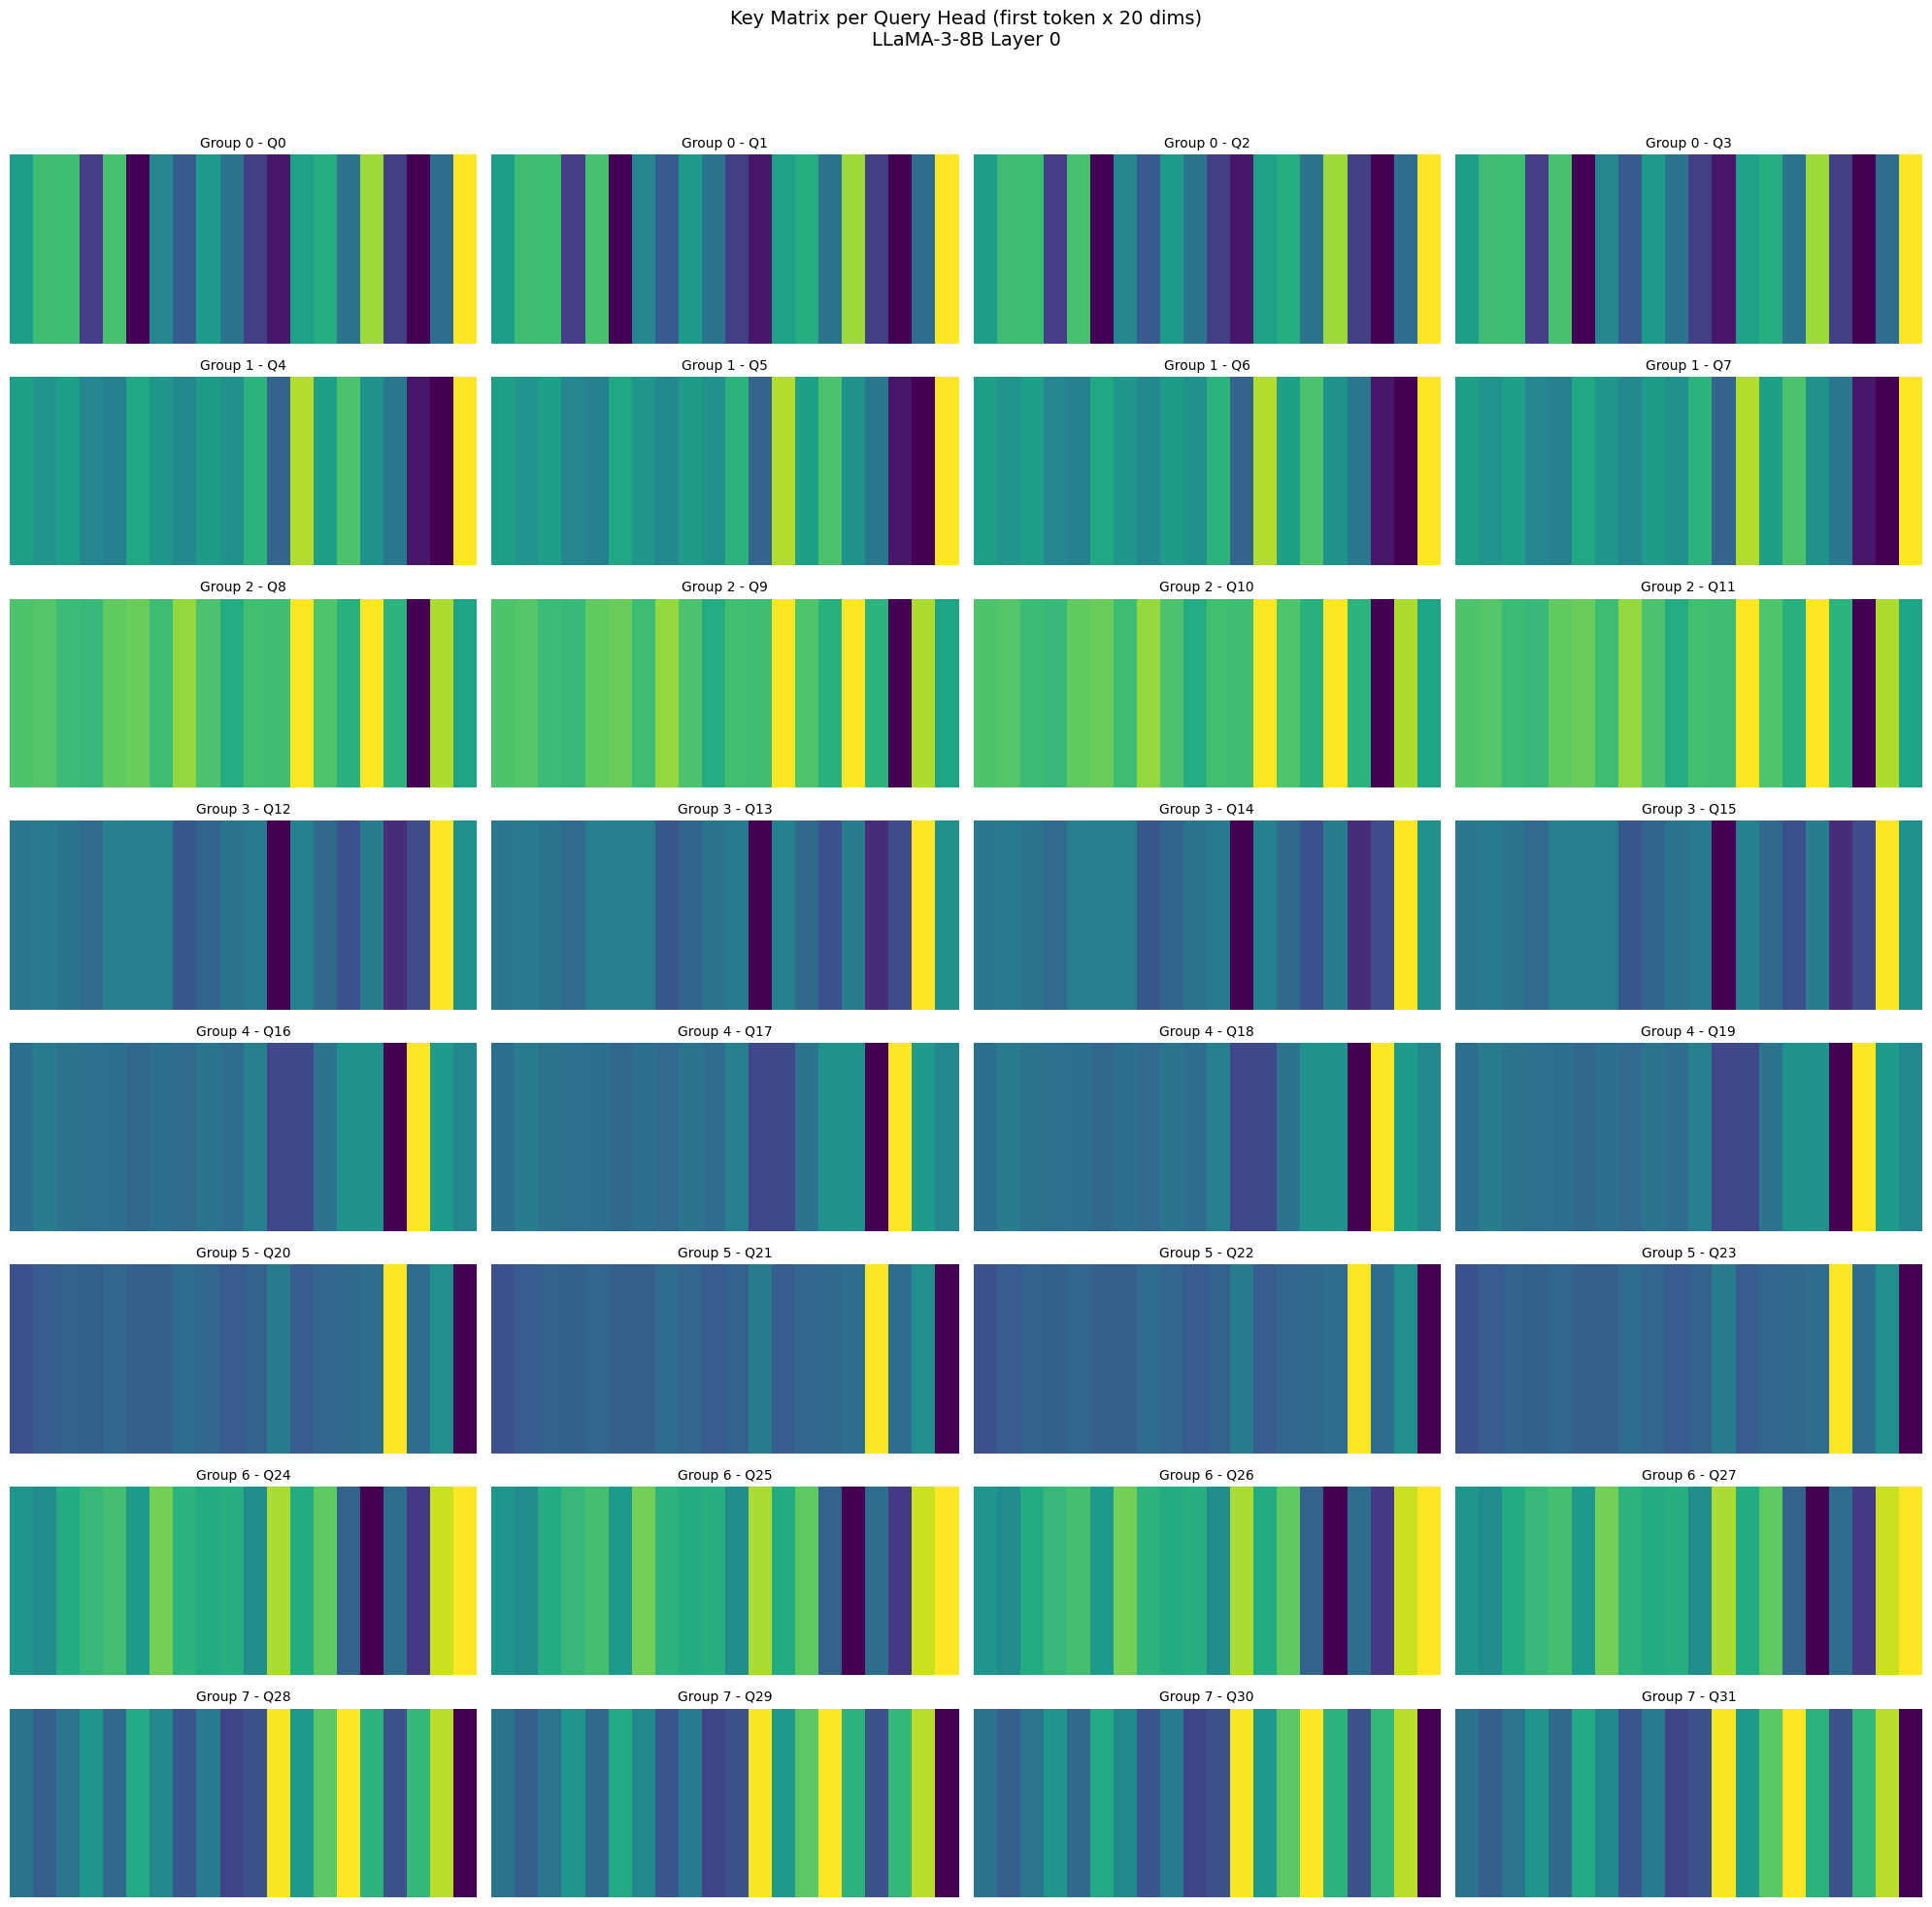

In [ ]:
from google.colab import userdata

# Step 1: Sign into Hugging Face
from huggingface_hub import login
login(userdata.get('HF_TOKEN'))

# Step 2: Load the Llama-3-8B model
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the LLaMA-3-8B model (requires token access)
model_name = "meta-llama/Meta-Llama-3-8B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Step 3: Visualize groups which share same key values
def visualize_gqa_keys_correct_mapping(input_text="Hello LLaMA!", layer_idx=0):
    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

    # Hook to capture k_proj output
    k_values = []

    def capture_k_hook(module, input, output):
        k_values.append(output.detach().cpu())

    # Register hook on the k_proj of the selected layer
    layer = model.model.layers[layer_idx]
    k_hook = layer.self_attn.k_proj.register_forward_hook(capture_k_hook)

    # Forward pass
    with torch.no_grad():
        _ = model(**inputs)

    k_hook.remove()

    # Extract key tensor
    k = k_values[0] # Shape: [batch, seq_len, kv_dim]
    batch_size, seq_len, kv_dim = k.shape

    # Get model config info
    num_q_heads = model.config.num_attention_heads       # 32
    num_kv_heads = model.config.num_key_value_heads      # 8
    head_dim = kv_dim // num_kv_heads                    # Typically 128

    # Reshape key tensor: [batch, seq_len, num_kv_heads, head_dim] -> [batch, num_kv_heads, seq_len, head_dim]
    k_heads = k.reshape(batch_size, seq_len, num_kv_heads, head_dim).transpose(1, 2)

    # Build mapping from Q head to KV head (GQA)
    q_to_kv_map = {q: q // (num_q_heads // num_kv_heads) for q in range(num_q_heads)}

    # Group Q heads by shared KV head
    kv_groups = {}
    for q_head, kv_head in q_to_kv_map.items():
        kv_groups.setdefault(kv_head, []).append(q_head)

    # === Visualization ===
    plt.figure(figsize=(20, 2.5 * len(kv_groups)))

    for row_idx, (kv_id, q_heads) in enumerate(kv_groups.items()):
        # All these heads share KV head `kv_id`, so we extract that once
        # key_matrix = k_heads[0, kv_id, 0:1, :20] # 1st token, first 20 dims

        for i, q_head in enumerate(q_heads):
            # All these heads share KV head `kv_id`, so we extract that once
            key_matrix = k_heads[0, kv_id, 0:1, :20] # 1st token, first 20 dims

            plt.subplot(len(kv_groups), len(q_heads), row_idx * len(q_heads) + i + 1)
            sns.heatmap(key_matrix, cmap='viridis', cbar=False)
            plt.title(f"Group {kv_id} - Q{q_head}", fontsize=10)
            plt.xticks([])
            plt.yticks([])

    plt.suptitle(f"Key Matrix per Query Head (first token x 20 dims)\nLLaMA-3-8B Layer {layer_idx}", fontsize=14)
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.savefig(f"llama3_layer_{layer_idx}_gqa_keys.png")
    plt.show()


# Run visualization
visualize_gqa_keys_correct_mapping(input_text="This is a test for grouped query attention.")